In [1]:
import pickle
from glob import glob
import numpy as np
from os import system
from scipy.optimize import minimize
from matplotlib import pyplot as plt

stds = []
Neffs = []
N = []
backgrounds = []
gammas = []
bias = []
stars = []
apertures = []
ages = []
for r in glob("results_old/*.dump"):
    #print(p)
    try:
        p, result = pickle.load(open(r,'rb'))
#    if len(result) == 1: 
    #print(len(result))
    except:
        system("rm "+r)
        continue
    #print(result.shape)
    if len(result) < 10**4:
        system("rm "+r)
        continue
    r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
    r50_0 = (2**(2/(p[0]-2))-1)**0.5
    r50[np.isnan(r50)] = np.inf
    Neff = p[3]
    gammas.append(p[0])
    background = p[1]
    stars.append(p[-1])
    apertures.append(p[2])
    ages.append((p[-1] if len(p)>6 else 1e8))
    N.append(p[3])
    std = np.diff(np.percentile(np.log10(r50/r50_0),[16,84]))[0]
    backgrounds.append(background)
    stds.append(std)
    bias.append(np.median(np.log10(r50/r50_0)[np.isfinite(r50)]))

gammas, ages, stds, N, backgrounds, bias, stars, apertures = np.array(gammas), np.array(ages), np.array(stds), np.array(N), np.array(backgrounds), np.array(bias), np.array(stars), np.array(apertures)
cut =  np.isfinite(stds) * (stds < 0.1) * (ages == 1e8) #* (backgrounds==1e-6)


/tmp/ipykernel_278017/1972205366.py:30: RuntimeWarning: overflow encountered in power
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
/tmp/ipykernel_278017/1972205366.py:30: RuntimeWarning: invalid value encountered in sqrt
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
/opt/intel/oneapi/intelpython/latest/envs/2023.2.0/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_278017/1972205366.py:46: RuntimeWarning: invalid value encountered in less
  cut =  np.isfinite(stds) * (stds < 0.1) * (ages == 1e8) #* (backgrounds==1e-6)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.215718667316622
        x: [-8.133e-01 -3.308e-01  1.773e-01  7.138e-01 -1.175e+00
             1.066e+00  6.235e-01 -1.651e+00]
      nit: 21
      jac: [ 1.949e-04  7.508e-03  6.487e-03 -3.737e-03  1.176e-03
            -3.154e-03  5.448e-03 -1.193e-03]
 hess_inv: [[ 3.212e+00  4.651e+00 ... -4.838e+00 -3.118e+00]
            [ 4.651e+00  9.662e+00 ... -7.512e+00 -4.381e+00]
            ...
            [-4.838e+00 -7.512e+00 ...  7.653e+00  4.801e+00]
            [-3.118e+00 -4.381e+00 ...  4.801e+00  4.475e+00]]
     nfev: 225
     njev: 25 [ 0.15371016  0.46683763  1.50407105  5.17331682  0.0668714  11.64234616
  4.20209194  0.02232416]


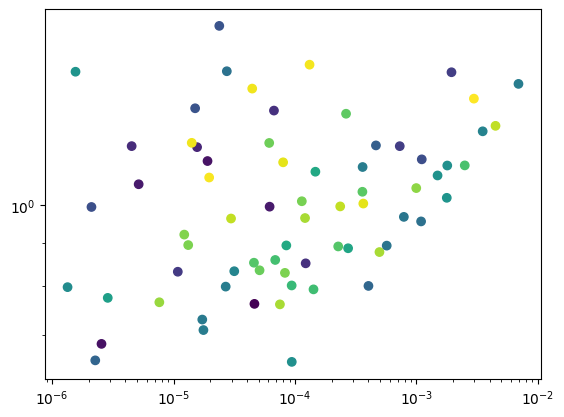

In [9]:
def model(x):
    Reff_model = (2**(2/(gammas[cut]-2)) - 1)**0.5
    Reff_SNR = 0.5 / (backgrounds[cut] * np.pi * Reff_model**2) # ratio of true counts within Reff to total counts
    ap_over_Reff = apertures[cut] / Reff_model
    m = 10**x[0] * N[cut]**-0.5  * (1 + (backgrounds[cut]/10**x[1])**x[2])*(1 + (ap_over_Reff/10**x[3])**x[4]) * (1 + 10**x[6]*(gammas[cut]-2)**x[7]) #np.exp(x[6]*(gammas[cut]-2)**x[7]) # + x[7])
    #m = 10**x[0] * N[cut]**-0.5 * np.exp((Reff_SNR/10**x[1])**x[2]) * np.exp((ap_over_Reff/10**x[3])**x[4]) * np.exp(10**x[6]*(gammas[cut]-2)**x[7]) # + x[7])
    #m = 10**x[0] * N[cut]**-0.5 * (Reff_SNR/10**x[1])**x[2] * (ap_over_Reff/10**x[3])**x[4]
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1])**x[2]) * (1 + (apertures[cut]/10**x[3])**x[4]) * (1 + (x[6]/(gammas[cut]-2))**x[7])
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1])**x[2]) * (1 + (apertures[cut]/10**x[3])**x[4]) * np.exp(x[6]*(gammas[cut]-2)**x[7]) 
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1])**x[2]) * (1 + (apertures[cut]/10**x[3])**x[4]) * (ages[cut]/1e8)**x[6]
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1] * N[cut]**x[6])**x[2]) * (1 + (apertures[cut]/10**x[3] * N[cut]**x[7])**x[4])
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1] * N[cut]**x[6])**x[2]) * (1 + (apertures[cut]/10**x[3])**x[4])
    if np.any(stars[cut]): m[stars[cut]] *= 10**x[5]
    return m

def lossfunc(x, *args):
    m = model(x)
    return np.mean(np.log(m/stds[cut])**2)**0.5

sol = minimize(lossfunc, (0.,0,0.5,0,0.5,1,0,-1), tol=1e-2)
#modelval = (10**sol[0] * N[cut]**-0.5 * (1 + backgrounds[cut]**sol[2]*10**sol[1]))
print(sol,10**sol.x)
plt.scatter(backgrounds[cut],stds[cut]/model(sol.x),c=gammas[cut]); plt.xscale('log'); plt.yscale('log')
#plt.scatter(gammas[cut],np.exp(1/(gammas[cut]-2)))



In [10]:
backgrounds.max()

0.038273751380044733

Using matplotlib backend: TkAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_9322/2088983458.py:19: RuntimeWarning: overflow encountered in power
  r50 = 10**loga_measured * np.sqrt(2 ** (2 / (np.array(gamma_measured) - 2)) - 1)
/tmp/ipykernel_9322/2088983458.py:19: RuntimeWarning: invalid value encountered in sqrt
  r50 = 10**loga_measured * np.sqrt(2 ** (2 / (np.array(gamma_measured) - 2)) - 1)


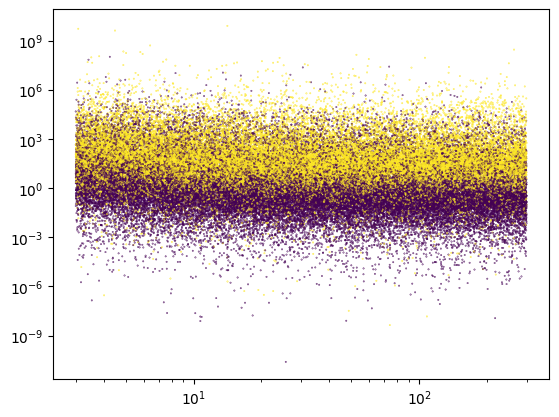

In [5]:
import numpy as np
%pylab
%matplotlib inline
from glob import glob
data = np.concatenate([np.load(r) for r in glob("results2/*.npy")])
(
    gammas,
    backgrounds,
    apertures,
    N,
    res,
    count_photons,
    loga_measured,
    gamma_measured,
) = data.T

count_photons = np.bool_(count_photons)
r50_0 = (2 ** (2 / (gammas - 2)) - 1) ** 0.5
r50 = 10**loga_measured * np.sqrt(2 ** (2 / (np.array(gamma_measured) - 2)) - 1)
dlogr = np.log10(r50 / r50_0)

#for 
bins = 
plt.scatter(apertures, dlogr**2*N,s=0.1,c=count_photons); plt.loglog()
plt.show()

Using matplotlib backend: TkAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


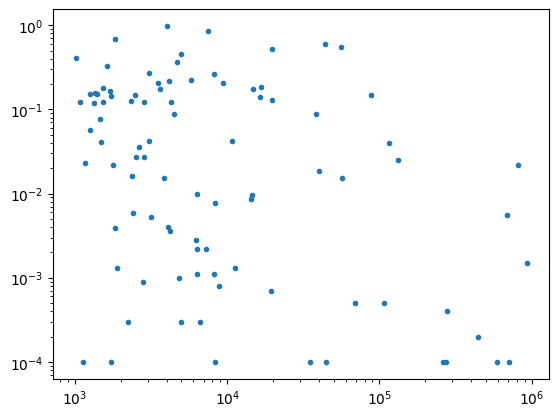

In [7]:
%pylab
%matplotlib inline
gammas, ages, stds, N, backgrounds, bias, stars, apertures, frac_inf = np.load("std_vs_frac.npy").T
plt.loglog(N,frac_inf,'.')
plt.show()
print((frac_inf>0.05).sum()/len(frac_inf))